<a href="https://colab.research.google.com/github/GouthamVicky/LLM-LongDoc-Summary/blob/main/Quantiphi_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLM Project**

## Problem Statement
Develop a customized LLM model that can generate a summary of a given document.

## Notebook Overview

This Google Colab notebook shows how to fine-tune the recent [Falcon-1B-RW](https://tiiuae/falcon-rw-1b) model onGoogle colab for Document Summarization Task

**Project Document Link** -

In [ ]:
!nvidia-smi

Tue Nov  7 19:35:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

Required libraries for Falcon Finetuning experiment



*   transformers
*   accelerate
*   bitsandbytes
*   wandb
*   sentence-transformers
*   PEFT



In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb
!pip install -U sentence-transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
pip install flash-attn --no-build-isolation

## Dataset

For our experiment, we will use the Arxiv Dataset (ccdv/arxiv-summarization) ,Dataset for summarization of long documents.

The dataset can be found [here](https://huggingface.co/datasets/ccdv/arxiv-summarization)

In [ ]:
from datasets import load_dataset
from random import randrange
import re
from random import randrange
import warnings


dataset_name = "ccdv/arxiv-summarization"

#For POC experiment we are loading a small amount data from data loader
dataset = load_dataset(dataset_name, split='train[:1%]')




print(f"dataset size: {len(dataset)}")
print(dataset[randrange(len(dataset))])



dataset size: 2030
{'article': "the kepler mission @xcite , with the discovery of over 4100 planetary candidates in 3200 systems , has spawned a revolution in our understanding of planet occurrence rates around stars of all types . \n one of kepler s profound discoveries is that small planets ( @xmath8 ) are nearly ubiquitous ( e.g. , * ? ? ? \n * ; * ? ? ? \n * ; * ? ? ? \n * ; * ? ? ? \n * ; * ? ? ? \n * ) and , in particular , some of the most common planets have sizes between earth - sized and neptune - sized  a planet type not found in our own solar system . \n indeed , it is within this group of super - earths to mini - neptunes that there is a transition from `` rocky '' planets to `` non - rocky planets '' ; the transition is near a planet radius of @xmath9 and is very sharp  occurring within @xmath10 of this transition radius @xcite .    unless an intra - system comparison of planetary radii is performed where only the relative planetary sizes are important @xcite , having acc

In [ ]:
# Limiting the dataset to 1000 datapoints
dataset=dataset.select([i for i in range(1000)])

## Import required libraries

For creating embedding, [sentence-transformers/paraphrase-MiniLM-L3-v2 ](https://sentence-transformers/paraphrase-MiniLM-L3-v2) has been used for clustering sentence embeddings

In [ ]:
import nltk
import pandas as pd
from nltk.cluster import KMeansClusterer
import numpy as np

import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from scipy.spatial import distance
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer,util

#Download Sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

nltk.download('punkt')
nltk.download('stopwords')

# Ignore all warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset

Dataset({
    features: ['article', 'abstract'],
    num_rows: 1000
})

## Preprocessing Steps



*  Tokenize the article into sentences using nltk's sentence tokenizer.
*  Generate contextual embeddings for each sentence using Sentence Transformer.
*  Cluster the sentences using K-means to group similar sentences.
*  Select the sentence closest to the cluster's centroid as the  sentence representation for each cluster.
*  Create the extractive summary using these sentences representation





In [ ]:
# Load NLTK stopwords
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(sentence):
    sentence = re.sub('[^a-zA-Z0-9.]', ' ', sentence)
    sentence = sentence.lower()
    tokens = sentence.split()
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def extractive_summary_generator(input_article_text):
    sentences = sent_tokenize(input_article_text)
    corpus = [clean_and_tokenize(sentence) for sentence in sentences]

    # Encode sentences using Sentence Transformers
    sentence_embeddings = model.encode(corpus)

    n_clusters = 20
    if len(sentence_embeddings) >= n_clusters:
        kmeans = KMeans(n_clusters, init='k-means++', random_state=42)
        y_kmeans = kmeans.fit_predict(sentence_embeddings)

        # Finding and printing the nearest sentence vector from cluster centroid
        my_list = []
        for i in range(n_clusters):
            my_dict = {}

            for j in range(len(y_kmeans)):
                if y_kmeans[j] == i:
                    my_dict[j] = distance.euclidean(kmeans.cluster_centers_[i], sentence_embeddings[j])

            if my_dict:  # Check if my_dict is not empty
                min_distance = min(my_dict.values())
                my_list.append(min(my_dict, key=my_dict.get))


        sentences = [sentences[i] for i in sorted(my_list) if len(sentences[i].split()) >= 4]
        extractive_summary = "\n".join(sentences)
        return extractive_summary
    else:
        return "\n".join(corpus)


def preprocess_text(text):
    #Remove special characters and extra whitespace
    text = re.sub(r'[^a-zA-Z0-9.\s]', '', text)
    text = ' '.join(text.split())

    # Remove extra spaces
    text = ' '.join(text.split())

    # Remove extra multi-line breaks
    text = re.sub(r'\n\s*\n', '\n\n', text)

    return extractive_summary_generator(text)


def remove_pattern_words(text):
    # Define patterns to match 'xmath' and 'xcite' and their variations
    pattern_xmath = r'xmath\d+'
    pattern_xcite = r'xcite'

    # Replace the pattern words with an empty string
    text_without_pattern_words = re.sub(pattern_xmath, '', text)
    text_without_pattern_words = re.sub(pattern_xcite, '', text_without_pattern_words)

    return text_without_pattern_words


def generate_prompt(arxiv_dataset):
    arxiv_dataset['prompts'] = remove_pattern_words(f"### Please give me a brief summary of this research paper\n" \
                              f"### Paper : {preprocess_text(str(arxiv_dataset['article']))}\n\n" \
                              f"### Summary : {str(arxiv_dataset['abstract'])}" if arxiv_dataset.get("abstract") else None)
    return arxiv_dataset

# Assuming you have a 'dataset' object, apply the transformations
dataset = dataset.map(generate_prompt, remove_columns=list(dataset.features))

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Check the Prompt format

from random import randint

print(dataset[randint(0, len(dataset))]["prompts"])

### Please give me a brief summary of this research paper
### Paper : however in the present work we will be focussing on the second of the above three stages of evolution of black hole perturbation in a regular black hole background in asymptotically de sitter space time .
coming back to the perturbations and stability of black holes in de sitter space there have been a lot of work  on quasinormal modes of scalar electromagnetic gravitational dirac perturbations decay of charged fields asymptotic quasinormal modes and signature of quantum gravity etc .
there were many works published regarding such regular black holes stability properties  qnms  thermodynamics  and geodesic structure  of regular black holes to mention a few .
in section 3 we present a brief discussion of wkb method along with a study of the scalar qnms of the bds black holes .
both the plots reveals that re  and i m  decreases with increasing  .
however the real part of qnms will increase as  increases .
in we showed 

## Data Split

 The dataset for training and evaluation splittede for SFT trainer

In [ ]:
dataset=dataset.train_test_split(test_size=0.3)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompts'],
        num_rows: 700
    })
    test: Dataset({
        features: ['prompts'],
        num_rows: 300
    })
})

## Loading the model

Model used for finetuning - [Falcon-1B-RW](https://tiiuae/falcon-rw-1b).

Bitsandbytes used for 4bit quantization configuration

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer ,AutoConfig

model_name = "tiiuae/falcon-rw-1b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)


# config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
# print(config)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     config=config,
#     load_in_4bit=True,
#     use_flash_attention_2=True
# )

model.config.use_cache = False

## Download Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

## PEFT Configuration

In [ ]:
from peft import LoraConfig

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

## Training Arguments

Parameters:
- `output_dir`: Directory to save the model and training logs.
- `per_device_train_batch_size`: Batch size per GPU device during training.
- `gradient_accumulation_steps`: Number of gradient accumulation steps.
- `optim`: Optimizer choice (e.g., 'adamw_hf').
- `save_steps`: Frequency of model checkpoint saving.
- `logging_steps`: Frequency of logging training progress.
- `learning_rate`: Initial learning rate.
- `fp16`: Whether to use mixed-precision training.
- `max_grad_norm`: Maximum gradient norm for gradient clipping.
- `max_steps`: Maximum number of training steps.
- `warmup_ratio`: Learning rate warm-up ratio.
- `group_by_length`: Group training data by sequence length.
- `lr_scheduler_type`: Type of learning rate scheduler.


In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 2
gradient_accumulation_steps = 16
#optim = "paged_adamw_32bit"
optim="adamw_hf"
save_steps = 50
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 500
warmup_ratio = 0.03
lr_scheduler_type = "cosine"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True, # Activates Mixed Precision Training
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True, #Saves Memory and speeds up the training
    lr_scheduler_type=lr_scheduler_type,
)

## Train on completions

**DataCollatorForCompletionOnlyLM** to train the model on the generated prompts only

In [ ]:
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
response_template = "### Summary :"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## SFT Trainer

Initialize the SFT Trainer Module and passing the trainer arguments

In [ ]:
from trl import SFTTrainer

max_seq_length =1024

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    peft_config=peft_config,
    dataset_text_field="prompts",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    data_collator=collator,
    args=training_arguments,
)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

pre-process the model by upcasting the layer norms in float 32 for more stable training

In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Model Configuration

In [ ]:
print(model.config)

FalconConfig {
  "_name_or_path": "tiiuae/falcon-rw-1b",
  "alibi": true,
  "apply_residual_connection_post_layernorm": false,
  "architectures": [
    "FalconForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "tiiuae/falcon-rw-1b--configuration_falcon.FalconConfig",
    "AutoModel": "tiiuae/falcon-rw-1b--modeling_falcon.FalconModel",
    "AutoModelForCausalLM": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForCausalLM",
    "AutoModelForQuestionAnswering": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForQuestionAnswering",
    "AutoModelForSequenceClassification": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForSequenceClassification",
    "AutoModelForTokenClassification": "tiiuae/falcon-rw-1b--modeling_falcon.FalconForTokenClassification"
  },
  "bias": true,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_dropout": 0.0,
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "falcon",
  "multi_query": false,
  

## Model Training


In [ ]:
trainer.train()

wandb: Currently logged in as: gouthamvicky (scispace). Use `wandb login --relogin` to force relogin


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,2.904700
20,2.684700
30,2.757900
40,2.696000
50,2.462600
60,2.559600
70,2.540600
80,2.199200
90,2.230000
100,2.075700


TrainOutput(global_step=500, training_loss=1.4188269004821776, metrics={'train_runtime': 2096.5688, 'train_samples_per_second': 7.632, 'train_steps_per_second': 0.238, 'total_flos': 9.465279698952192e+16, 'train_loss': 1.4188269004821776, 'epoch': 22.86})

In [ ]:
# Save trained model
finetuned_model_name="falcon-arxiv-long-summary-1B"


In [ ]:
trainer.model.save_pretrained(finetuned_model_name)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Push to HUB

Uploading the LORA adapter to Huggingface Modelhub

Model Card - [GouthamVignesh/FalconArxivPeft](https://https://huggingface.co/GouthamVignesh/falcon-arxiv-long-summary-1B)

In [ ]:
trainer.model.push_to_hub("GouthamVignesh/falcon-arxiv-long-summary-1B")

adapter_model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/GouthamVignesh/falcon-arxiv-long-summary-1B/commit/af6bef9a1f5b3b328550124905423cf332ddec32', commit_message='Upload model', commit_description='', oid='af6bef9a1f5b3b328550124905423cf332ddec32', pr_url=None, pr_revision=None, pr_num=None)

# W&B Metrics

Train/Loss Graph 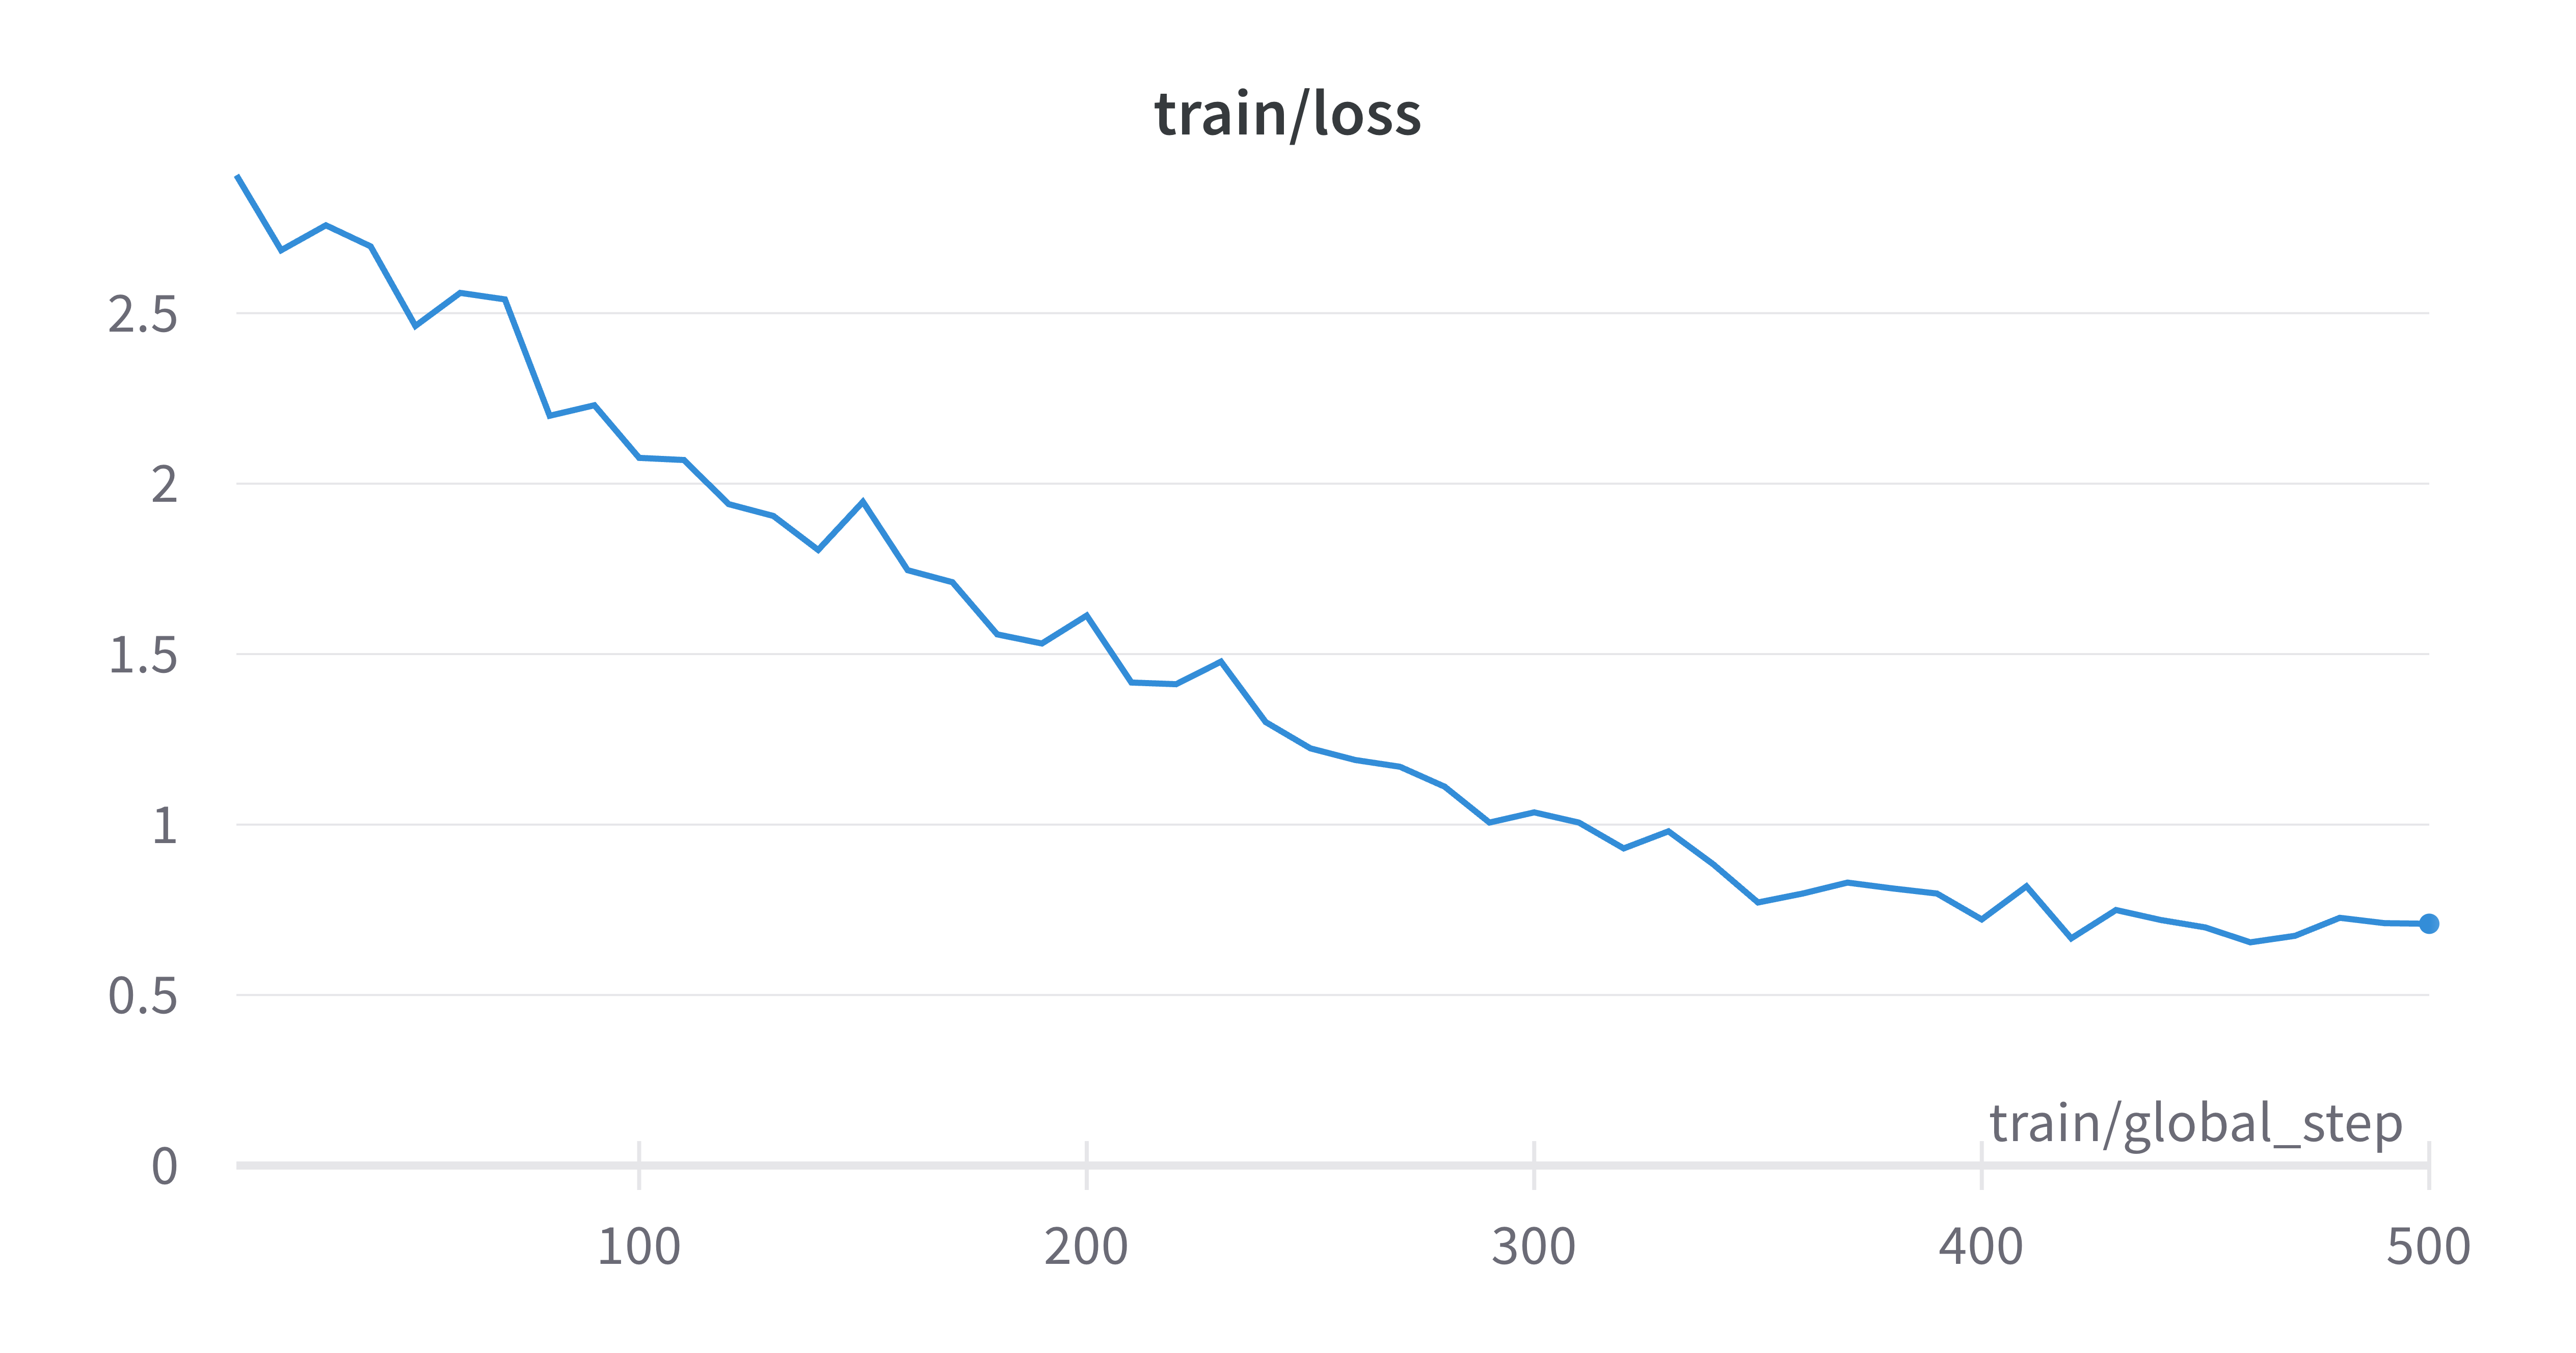

## Merge LORA adapter

Merge and load the adapter to the base model


In [ ]:
# Empty VRAM
del model
del trainer
import gc
gc.collect()
gc.collect()

22665

In [ ]:
from peft import LoraConfig, PeftModel

# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda",
)
model = PeftModel.from_pretrained(base_model, finetuned_model_name)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

## Push to HUB

Uploading the Merged model to Huggingface Modelhub

Model Card - [GouthamVignesh/falcon-arxiv-long-summary-1B](https://huggingface.co/GouthamVignesh/falcon-arxiv-long-summary-1B)

In [ ]:
model.push_to_hub(finetuned_model_name, use_temp_dir=False)
tokenizer.push_to_hub(finetuned_model_name, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/GouthamVignesh/falcon-arxiv-long-summary-1B/commit/ef1627e3ee3e447a573f6aaa79e950a49a05f018', commit_message='Upload tokenizer', commit_description='', oid='ef1627e3ee3e447a573f6aaa79e950a49a05f018', pr_url=None, pr_revision=None, pr_num=None)

#Saving the bin File

In [ ]:
torch.save(model.state_dict(), "pytorch_model.bin")

In [ ]:
!huggingface-cli upload GouthamVignesh/falcon-long-summary-ckpt pytorch_model.bin

pytorch_model.bin: 100% 2.62G/2.62G [04:24<00:00, 9.90MB/s]
https://huggingface.co/GouthamVignesh/falcon-long-summary-ckpt/blob/main/pytorch_model.bin
